# Bee Image Classification using a CNN to detect Varroa mite infestation

#### Author: Mahdi Shadkam-Farrokhi: [GitHub](https://github.com/Shaddyjr) | [Medium](https://medium.com/@mahdis.pw) | [LinkedIn](https://www.linkedin.com/in/mahdi-shadkam-farrokhi-m-s-8a410958/) | [mahdis.pw](http://mahdis.pw)

## Problem Statement
Beekeepers must face a myriad of threats to their hives. The _Varroa (pronounced "vr-ow-uh") destructor_, or more commonly the _varroa mite_, is a natural predator to honey bees and is one of the biggest pests plaguing the bee keeping community. The sooner a keeper can begin treating for _varroa_, the less likely a [colony collapse](https://ipm.missouri.edu/MPG/2013/7/Colony-Collapse-Disorder-the-Varroa-Mite-and-Resources-for-Beekeepers/) will occur.  Early detection could mean the difference between a healthy hive and a dead one. 

We plan to create such an early detection tool by using the dataset from the [Honey Bee Annotated Image Dataset](https://www.kaggle.com/jenny18/honey-bee-annotated-images) found on Kaggle. With these annotated images, we will train a Convolutional Neural Network (CNN) to classify bee images as having _varroa mites_ or not (binary classification).

Accuracy will be our metric for model selection.

## Table of contents

- [Data Dictionary](#Data-Dictionary)
- [Imports and loading Data](#Imports-and-loading-Data)
- [Preliminary EDA](#Preliminary-EDA)
    - [Handling target variable](#Handling-target-variable)
    - [Clearing unnecessary columns](#Clearing-unnecessary-columns)
    - [Visualizing file images](#Visualizing-file-images)
- [Source Documentation](#Source-Documentation)

## Data Dictionary
The data used for this analysis was taken directly from the [Honey Bee Annotated Image Dataset](https://www.kaggle.com/jenny18/honey-bee-annotated-images) fround on Kaggle.

The following is the data dictionary for the original dataset:

|column|type|description|
|-|-|-|
|file|string|name of file in 'bee_imgs' folder|
|date|string|date image was captured|
|time|string|time of day of image capture (military time)|
|location|string|Location (city, state, country)|
|zip|int| Zip code of the location|
|subspecies|string|Subspecies of _Apis mellifera_ species|
|health|string|Health of the bee|
|pollen_carrying|boolean|Presence of pollen on the bee's legs|
|caste|string|Worker, Drone, or Queen bee|

## Imports and loading Data

#### Saving/Loading model weights

In [8]:
# best_model["best_model"].save_weights('orig_1.h5')

In [9]:
# model = build_model_from_datagen(params=permutate_params(grid_params)[0], input_shape=resizing, load_weights='orig_1.h5')

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import imageio
from skimage.transform import rescale, resize, rotate
from skimage.color import rgb2gray
from sklearn.metrics import confusion_matrix, auc, accuracy_score
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop, SGD
from keras import callbacks
from keras.models import load_model

import warnings
warnings.filterwarnings("ignore")

random_state = 42

# For reproducibility
np.random.seed(random_state)

#### Saving/Loading model weights

In [11]:
# best_model["best_model"].save_weights('orig_1.h5')

In [12]:
# model = build_model_from_datagen(params=permutate_params(grid_params)[0], input_shape=resizing, load_weights='orig_1.h5')

In [13]:
data = pd.read_csv('./data/bee_data.csv')

In [14]:
data.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


In [15]:
data.shape

(5172, 9)

## Preliminary EDA

### Handling target variable

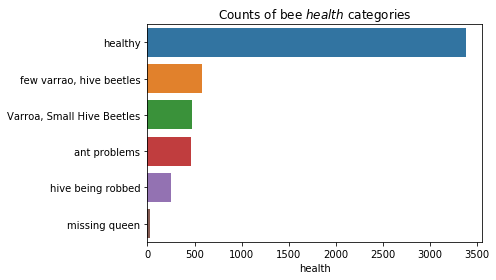

In [16]:
health_counts = data["health"].value_counts()

plt.title("Counts of bee $health$ categories")
sns.barplot(x = health_counts, y = health_counts.index);

The `healthy` and varroa-associated categories are the observations of interest and comprise the majority of total observations in the dataset. 

_The other observations will be dropped_

In [17]:
target_categories = [name for name in health_counts.index if "varr" in name.lower() or "health" in name.lower()]
data = data[[status in target_categories for status in data["health"]]]
data["has_varroa"] = (data["health"] != "healthy").astype(int)

In [18]:
data.shape

(4435, 10)

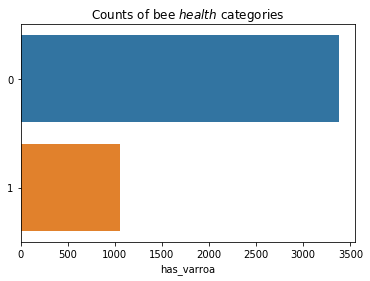

In [19]:
health_counts = data["has_varroa"].value_counts()

plt.title("Counts of bee $health$ categories")
sns.barplot(x = health_counts, y = health_counts.index, orient="h");

### Establishing baseline model

In [20]:
data["has_varroa"].value_counts(normalize = True)

0    0.763021
1    0.236979
Name: has_varroa, dtype: float64

These data are somewhat unbalanced, with the observation of interest accounting for almost 24% of the data.

With 76% of the dataset consisting of healthy bees, this serves as the baseline model's accuracy. Any model with an accuracy significantly higher than 76% can be considered superior to this naive model.

In [21]:
data.groupby("location").mean()[["has_varroa"]]

,has_varroa
location,
"Athens, GA, USA",1
"Athens, Georgia, USA",1
"Des Moines, IA, USA",0
"Keene, NH, USA",0
"New Orleans, LA, USA",0
"San Jose, CA, USA",0
"Saratoga, CA, USA",0


Apparently only two locations actually showcased varroa, which could train the model on factors unrelated to infected bees, such as classifying aspects of the location (parts of the image background) and/or the photographer's style (angle of shot, orientation, etc.).

### Clearing unnecessary columns
While a typical model would benefit from the image annotations, we're attempting to make practical classifications based solely on a user's image. As such, most of the columns in the dataset are irrelevant.

In [22]:
data.head(1)

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste,has_varroa
74,017_029.png,8/6/18,13:21,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker,0


In [23]:
data = data[["file","has_varroa"]]
data.head(2)

,file,has_varroa
74,017_029.png,0
75,017_015.png,0


###  Visualizing file images
Viewing the actual images that will be used to train the CNN may help inform how best to approach potentially cleaning and/or preparing the images for classification training.

In [24]:
def get_image_data(files):
    IMAGE_FILE_ROOT = './data/bee_imgs/' 
    return np.asanyarray([imageio.imread("{}{}".format(IMAGE_FILE_ROOT, file)) for file in files])

In [25]:
def show_image(image, ax = plt, title = None, show_size = False):
    ax.imshow(image)
    if title:
        ax.set_title(title)
    if not show_size:
        ax.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)

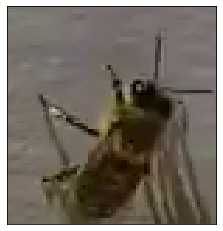

In [26]:
raw_images = get_image_data(data["file"].values)
show_image(raw_images[0])

In [27]:
def show_images(files, titles = None, show_size = False):
    cols = 4
    f, ax = plt.subplots(nrows=int(np.ceil(len(files)/cols)),ncols=cols, figsize=(14,5))
    ax = ax.flatten()
    for i, file in enumerate(files):
        if titles:
            show_image(file, ax = ax[i], title = titles[i], show_size = show_size)
        else:
            show_image(file, ax = ax[i], title = None, show_size = show_size)
    plt.show()

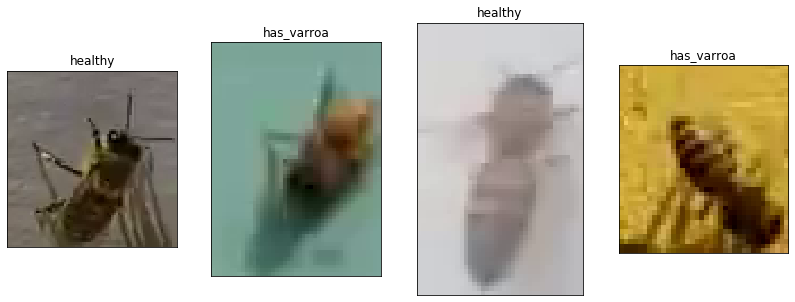

In [28]:
show_images(raw_images[::1200],list(data["has_varroa"].map({1:"has_varroa",0:"healthy"})[::1200]))

These pixelated images will be digested and processed by the CNN to descern the bee's classfication. 

However, from quickly viewing just a handful of these images, a number of images have low resolution leading to inconsistent data quality. For example, the 2nd image above shows a bee with varroa, which appears as little more than a blob. 

Can a CNN accurately discern the difference between one blob and another? If it can, is it really learning to distinguish an infected bee from a healthy one, or is it learning to distinguish something else, like the background?

Additionally, we must consider the varying image sizes, which must be standardized before feeding it through the convolutional layer. Cropping or rescaling the images will either lose data or distort the image reducing data and clarity.

### Discovering most frequent image shape

Since the CNN will need a consistent format, resizing makes the most practical as a way to lose the least data.

To discern the ideal width and height, we will find the most common (50% of the data) range of widths and heights and take the average. In this way, the majority of the data will be distorted the least.

In [29]:
def get_images_wh(images):
    widths = []
    heights = []
    for image in images:
        h, w, rbg = image.shape
        widths.append(w)
        heights.append(h)
    return (widths, heights)

In [30]:
def get_best_average(dist, cutoff = .5):
    # requires single peak normal-like distribution
    hist, bin_edges = np.histogram(dist, bins = 25);
    total_hist = sum(hist)
    hist_edges = [(vals[0]/total_hist,vals[1]) for vals in zip(hist, bin_edges)]
    hist_edges.sort(key = lambda x: x[0])
    lefts = []
    while cutoff > 0:
        vals = hist_edges.pop()
        cutoff -= vals[0]
        lefts.append(vals[1])
    diff = np.abs(np.diff(lefts)[0]) # same diff b/c of bins
    leftmost = min(lefts)
    rightmost = max(lefts) + diff
    return int(np.round(np.mean([rightmost,leftmost])))

In [31]:
wh = get_images_wh(raw_images)

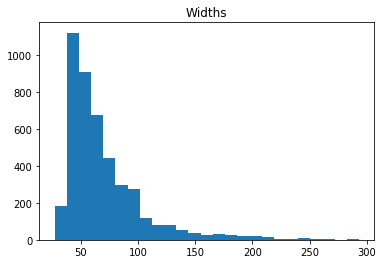

In [32]:
plt.title("Widths")
plt.hist(wh[0], bins = 25);

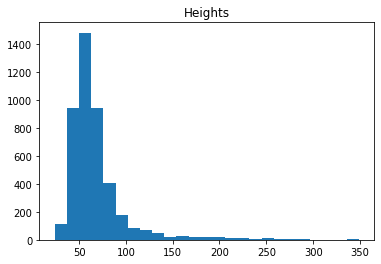

In [33]:
plt.title("Heights")
plt.hist(wh[1], bins = 25);

In [34]:
IDEAL_WIDTH, IDEAL_HEIGHT = get_best_average(wh[0]), get_best_average(wh[1])
IDEAL_WIDTH, IDEAL_HEIGHT

(54, 50)

Resizing images to 54x50 will do the least to alter the original image for the majority of the data.

## ImageHandler Class

It was inconvenient working with image data directly, especially when wanting to transform images for both modeling and visualization.

The `ImageHandler` class was created to simplify working with image data, while also allowing for intuitive transformations in a consolidated way.

Documentation can be [found here](./ImageHandler_doc.ipynb), and the source code can be [found here](./image_handler/ImageHandler.py).

In [35]:
from image_handler import ImageHandler

### Resizing images

In [36]:
resizing = (IDEAL_WIDTH, IDEAL_HEIGHT, 3)

sample_img_store = ImageHandler(raw_images[:201]).resize(resizing)

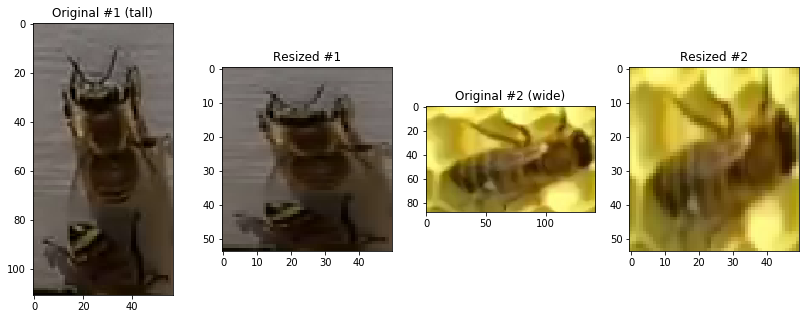

In [37]:
old_image_1 = raw_images[100]
new_image_1 = sample_img_store.images_for_display[100]

old_image_2 = raw_images[200]
new_image_2 = sample_img_store.images_for_display[200]
show_images(
    [old_image_1, new_image_1, old_image_2, new_image_2], 
    titles = ["Original #1 (tall)", "Resized #1", "Original #2 (wide)", "Resized #2"], 
    show_size = True
)

For the most part, the images are not terribly perturbed by resizing them to a standard width and height. Of course, the resizing process must be taken into consideration when interpreting the results. This also calls into question of the applicability of the model to real world images, which may require more nuanced methodd for standardizing original images.

## Model Preparation

In [104]:
def normalize(image):
    return (image/255. - 0.5)

In [105]:
def create_datagens(
    data, x_col, y_col, datagen_params, 
    target_shape, batch_size, IMAGE_FILE_ROOT = './data/bee_imgs/', 
    random_state = None, preprocessing_function = None):
        
        data[y_col] = data[y_col].astype(str) # coercion needed for datagen
        # train/test split
        train, test = train_test_split(
            data, 
            test_size = .25, 
            stratify = data.iloc[:,-1], # assumed last column is target variable
            random_state = random_state
            )
        
        datagen = ImageDataGenerator(
            horizontal_flip  = datagen_params.get("horizontal_flip") or False, 
            vertical_flip    = datagen_params.get("vertical_flip") or False, 
            rotation_range   = datagen_params.get("rotation_range") or False,
            brightness_range = datagen_params.get("brightness_range"),
            preprocessing_function = preprocessing_function
        )

        datagen_iter_train = datagen.flow_from_dataframe(
            train, 
            directory   = IMAGE_FILE_ROOT, 
            x_col       = x_col,
            y_col       = y_col,
            target_size = target_shape, 
            color_mode  = 'rgb', 
            class_mode  = 'binary', 
            batch_size  = batch_size, 
            shuffle     = True,
            seed        = random_state
        )

        datagen_test = ImageDataGenerator(preprocessing_function = preprocessing_function)

        datagen_iter_test = datagen_test.flow_from_dataframe(
            test, 
            directory   = IMAGE_FILE_ROOT, 
            x_col       = x_col,
            y_col       = y_col,
            target_size = target_shape, 
            color_mode  = 'rgb', 
            class_mode  = 'binary', 
            batch_size  = len(test), 
            shuffle     = False
        )
        
        return datagen_iter_train, datagen_iter_test

In [111]:
datagen_train, datagen_test = create_datagens(
                                    data, 
                                    datagen_params = dict(),
                                    x_col = "file", 
                                    y_col = "has_varroa", 
                                    target_shape = (IDEAL_HEIGHT, IDEAL_WIDTH), 
                                    batch_size = 64, 
                                    preprocessing_function = normalize,
                                    random_state = random_state
                                )

Found 3326 validated image filenames belonging to 2 classes.
Found 1109 validated image filenames belonging to 2 classes.


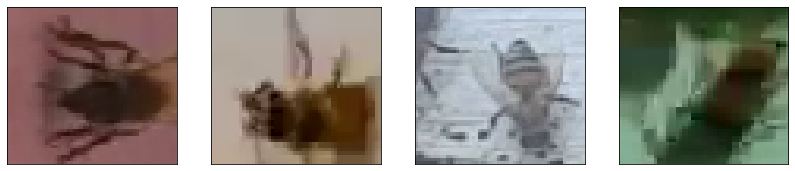

In [112]:
datagen_train.reset()
for x in datagen_train.next():
    show_images(x[:4]+.5)
    break

## gridSearchCNN + helper functions
Neural Networks are fitted using multiple hyperparameters. As such, it can prove difficult to tune and optimize a model.

The `gridSearchCNN`, and a number of other helper functions, were created to programmatically optimize this tuning process.

In [39]:
def permutate_params(grid_params):
    '''Returns a list of all combinations of unique parameters from the given dictionary'''
    out = [{}]
    for param_name, param_list in grid_params.items():
        if len(param_list) == 1:
            for item in out:
                item[param_name] = param_list[0]
        else:
            temp_out = []
            for param_val in param_list:
                for item in out:
                    cloned_item = item.copy()
                    cloned_item[param_name] = param_val
                    temp_out.append(cloned_item)
            out = temp_out
    return out

In [63]:
def build_model_from_datagen(
    params = dict(), 
    input_shape = (), 
    datagen_iter_train = None, 
    datagen_iter_val = None, 
    load_weights = None, 
    optimizer = "adam",
    save_best = False
):
    '''Returns a fitted convolutional neural network with the given parameters and data.'''
    kernel_size = 3
    dropout = .5
    activation_func = "relu"

    conv__filters_1 = params.get('conv__filters_1') or 32
    conv__filters_2 = params.get('conv__filters_2') or 16
    conv__filters_3 = params.get('conv__filters_3') or 32
    density_units_1 = params.get('density_units_1') or 32
    density_units_2 = params.get('density_units_2') or 32
    epochs          = params.get('epochs') or 8
    
    # instantiating model
    model = Sequential([
        # Conv layer #1
        Conv2D(
            filters = conv__filters_1, 
            kernel_size = kernel_size + 4, 
            activation  = activation_func, 
            input_shape = input_shape, #input layer
            padding     = "same"
        ),
        Conv2D(filters = conv__filters_1, kernel_size = kernel_size + 4, activation = activation_func, padding = "same"),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(dropout/2),

        # Conv layer #2
        Conv2D(filters = conv__filters_2, kernel_size = kernel_size + 2, activation=activation_func, padding = "same"),
        Conv2D(filters = conv__filters_2, kernel_size = kernel_size + 2, activation = activation_func, padding = "same"),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(dropout/2),

        # Conv layer #3
        Conv2D(filters = conv__filters_3, kernel_size = kernel_size, activation=activation_func, padding = "same"),
        Conv2D(filters = conv__filters_3, kernel_size = kernel_size, activation = activation_func, padding = "same"),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(dropout/2),

        # Dense layer #1
        Flatten(),
        Dense(density_units_1, activation=activation_func),
        Dropout(dropout),
        
        # Dense layer #2
        Dense(density_units_2, activation=activation_func),
        Dropout(dropout),
        
        # Output layer
        Dense(1, activation='sigmoid')
    ])
    
    # compiling model
    model.compile(
        loss      = 'binary_crossentropy',
        optimizer = optimizer,
        metrics   = ['binary_accuracy']
    )
    
    # loading previous model weights
    if load_weights:
        model.load_weights(load_weights)
        if not datagen_iter_train:
            return model
    
    # fitting model w/ImageDataGenerator
    STEP_SIZE_TRAIN= np.ceil(datagen_iter_train.n//datagen_iter_train.batch_size)
    STEP_SIZE_VALID= np.ceil(datagen_iter_val.n//datagen_iter_val.batch_size)

    history = model.fit_generator(
        generator           = datagen_iter_train,
        steps_per_epoch     = STEP_SIZE_TRAIN,
        validation_data     = datagen_iter_val,
        validation_steps    = STEP_SIZE_VALID,
        epochs              = epochs,
        callbacks           = [callbacks.ModelCheckpoint('models/model.{epoch:02d}-{val_binary_accuracy:.2f}.h5', save_best_only=True, mode='auto', period=1) if save_best else None]
    )
    
    return (model, history)

In [116]:
def gridSearchCNN(
    datagens,
    grid_params, 
    optimizer = "adam", 
    save_best = False,
    random_state = None
):
    '''
    Iteratively discovers and then returns an optimized convolutional neural network with the given parameters
    
    Much of the code related to datagen came from:
    https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720
    '''
    all_params = permutate_params(grid_params) # list of all parameter combinations
    
    best_model = None
    best_score = 0.0 # no accuracy to start
    best_params = None
    best_history = None
    
    datagen_iter_train, datagen_iter_test = datagens
    
    for params in all_params:
        model, history = build_model_from_datagen(
            params, 
            input_shape        = datagen_iter_train.image_shape,
            datagen_iter_train = datagen_iter_train,
            datagen_iter_val   = datagen_iter_test,
            optimizer          = optimizer,
            save_best          = save_best
        )

        datagen_iter_test.reset()

        STEP_SIZE_TEST= np.ceil(datagen_iter_test.n//datagen_iter_test.batch_size)

        pred = model.predict_generator(
            datagen_iter_test,
            steps=STEP_SIZE_TEST,
            verbose=1
        )

        predictions = (pred > .5).astype(int).flatten()
        acc = conf_matrix_stats(y[y_col].astype(int), predictions)["accuracy"]
        
        if acc > best_score:
            print("***Good Accurary found: {:.2%}***".format(acc))
            best_score = acc
            best_model = model
            best_params = params
            best_history = history
    return {
        "best_model"   : best_model,
        "best_score"   : best_score,
        "best_params"  : best_params,
        "generators"   : [
            datagen_iter_train,
            datagen_iter_test
        ],
        "best_history" : best_history,
        "incorrect_indeces"   : y.index[predictions!= y[y_col].astype(int)]
    }
    

In [46]:
def conf_matrix_stats(y_test, preds):
    ''' Return key confusion matrix metrics given true and predicted values'''
    cm = confusion_matrix(y_test, preds)
    TP, FP, FN, TN, = cm[1,1], cm[0,1], cm[1,0], cm[0,0]
    total = (TP + FP + FN + TN)
    acc = (TP + TN ) / total
    miss = 1 - acc
    sens = TP / (TP + FN)
    spec = TN / (TN + FP)
    prec = TP / (TP + FP)
    return {"accuracy": acc, "miss_rate": miss, "sensitivity": sens, "specification": spec, "precision": prec}

In [42]:
def graph_loss(history):
    # Check out our train loss and test loss over epochs.
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    xticks = np.array(range(len(train_loss)))
    # Set figure size.
    plt.figure(figsize=(12, 8))

    # Generate line plot of training, testing loss over epochs.
    plt.plot(train_loss, label='Training Loss', color='#185fad')
    plt.plot(test_loss, label='Testing Loss', color='orange')

    # Set title
    plt.title('Training and Testing Loss by Epoch', fontsize = 25)
    plt.xlabel('Epoch', fontsize = 18)
    plt.ylabel('Binary Crossentropy', fontsize = 18)
    plt.xticks(xticks, xticks+1)

    plt.legend(fontsize = 18);

## Model Exploration
Image data can be transformed in a variety of ways. Depending on the transformation a better model can be discovered. As such, the following transformations are of interest:

1. No transformation (original dataset)
2. Rotated and Mirrored transformation
3. Inverted transformation + original dataset
4. Grayscale transformation
5. Rotated and Mirrored + Inverted + Grayscale transformation

It is important to note, the image data must always be standardized to the same width and height first. A normalization transformation is also applied as part of this standardizing process.

> "Normalizing the input of your network is a well-established technique for improving the convergence properties of a network"
> \- Jeremy Jordan

[source](https://www.jeremyjordan.me/batch-normalization/)

The following visualization functions will be used to show images of the false positive and false negatives based on model results.

In [43]:
def show_results(images, shapes, title, ncols = 4, height = 2):
    nrows = int(np.ceil(len(images)/ncols))
    f, ax = plt.subplots(nrows=nrows,ncols=ncols, figsize=(10,nrows * height))
    ax = ax.flatten()
    for i, image in enumerate(images):
        _title = f"Orig. size: {shapes[i][0]}x{shapes[i][1]}\n{title}"
        show_image(image, ax = ax[i], title = _title)
    plt.tight_layout()
    plt.show()

## No transformation (original dataset)
By using the original (standardized) images, we can effectively set a basis for comparison for the set of transformations we're interested in.

### Model Preparation

In [119]:
datagen_params = dict()

datagens = create_datagens(
    data, 
    datagen_params = datagen_params,
    batch_size = 64,                 # hyperparameter
    x_col = "file", 
    y_col = "has_varroa", 
    target_shape = (IDEAL_HEIGHT, IDEAL_WIDTH), 
    preprocessing_function = normalize,
    random_state = random_state
)

grid_params = {
    "conv__filters_1" : [32],
    "conv__filters_2" : [48],
    "conv__filters_3" : [64],
    "density_units_1" : [256],
    "density_units_2" : [64],
    "batch_size" : [64],
    "epochs" : [1]
}

best_original_model = gridSearchCNN(
    datagens = datagens,
    grid_params = grid_params, 
    random_state=random_state,
    optimizer = RMSprop(lr=0.0001, decay=1e-6),
    save_best = True
)

Found 3326 validated image filenames belonging to 2 classes.
Found 1109 validated image filenames belonging to 2 classes.
Epoch 1/1
1/1 [==============================] - 3s 3s/step


NameError: name 'y' is not defined

In [50]:
best_original_model

{'best_model': <keras.engine.sequential.Sequential at 0x201d18f7518>,
 'best_score': 0.9936880072137061,
 'best_params': {'conv__filters_1': 32,
  'conv__filters_2': 48,
  'conv__filters_3': 64,
  'density_units_1': 256,
  'density_units_2': 64,
  'batch_size': 64,
  'epochs': 50},
 'generators': [<keras_preprocessing.image.dataframe_iterator.DataFrameIterator at 0x201d196d0b8>,
 'best_history': <keras.callbacks.History at 0x201d3cfbd30>,
 'incorrect_indeces': Int64Index([4246, 4194, 3101, 3369, 4978, 1582, 1719], dtype='int64')}

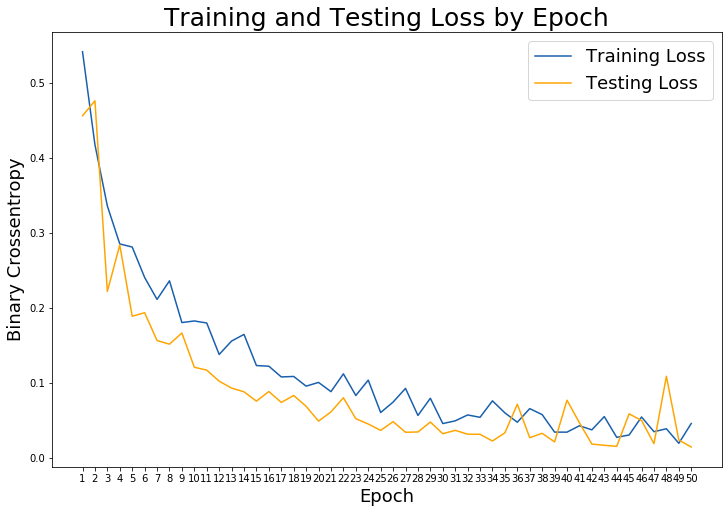

In [51]:
graph_loss(best_original_model["best_history"])

In [52]:
best_original_model = load_model("models/original.h5")

In [53]:
datagen_iter_test = best_original_model["generators"][1]
datagen_iter_test.reset()
STEP_SIZE_TEST= np.ceil(datagen_iter_test.n//datagen_iter_test.batch_size)

TypeError: 'Sequential' object is not subscriptable

In [198]:
_preds = model.predict_generator(datagen_iter_test, steps=STEP_SIZE_TEST)
preds = (_preds >= .5).astype(int).flatten()

In [199]:
orig_preds = pd.DataFrame({
    "file"       : datagen_iter_test.filenames,
    "has_varroa" : datagen_iter_test.classes,
    "pred"       : preds
})

In [200]:
(orig_preds["has_varroa"] == orig_preds["pred"]).value_counts(normalize=True)

True     0.995491
False    0.004509
dtype: float64

~99.55% Acc.

### Evaluating Model Errors

In [203]:
orig_missed = orig_preds[orig_preds["has_varroa"] != orig_preds["pred"]]
orig_missed.head()

,file,has_varroa,pred
136,040_047.png,1,0
155,031_065.png,1,0
314,028_025.png,0,1
496,040_401.png,1,0
987,005_448.png,0,1


#### False positives

In [3]:
false_positives_files = orig_missed[(orig_missed["has_varroa"] != orig_missed["pred"]) & (orig_missed["pred"] == 1)]["file"]
_images = get_image_data(false_positives_files)
show_images(_images, [image.shape for image in _images], "false pos.")

NameError: name 'orig_missed' is not defined

#### False negatives

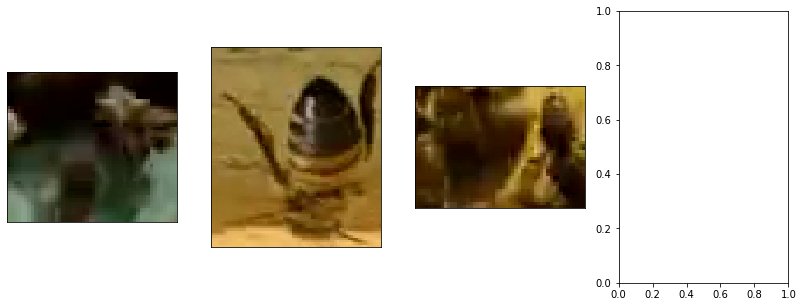

In [204]:
false_negatives_files = orig_missed[(orig_missed["has_varroa"] != orig_missed["pred"]) & (orig_missed["pred"] == 0)]["file"]
show_images(get_image_data(false_negatives_files))

#### Saving/Loading model weights

In [334]:
# best_model["best_model"].save_weights('orig_1.h5')

In [336]:
# model = build_model_from_datagen(params=permutate_params(grid_params)[0], input_shape=resizing, load_weights='orig_1.h5')

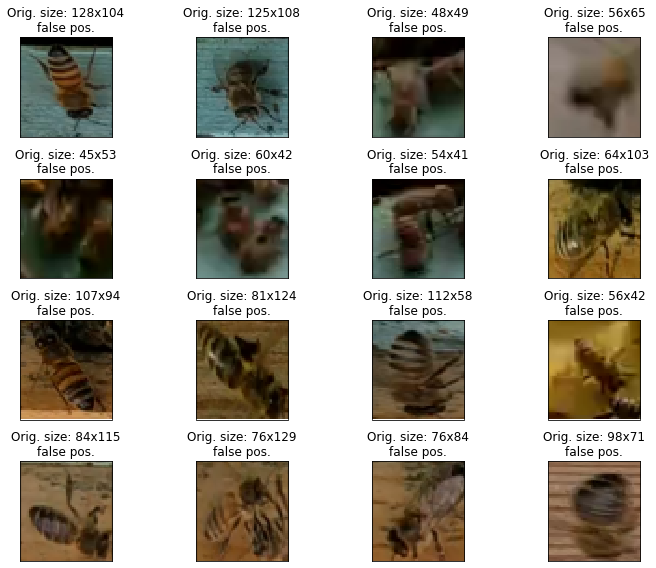

In [73]:
false_pos_mask = [i for i,result in enumerate(results) if result == -1]
false_positives = img_store.images_for_display[false_pos_mask]
original_false_pos_shapes = [image.shape for image in raw_images[false_pos_mask]]
show_results(false_positives, original_false_pos_shapes, "false pos.")

We can see these false positives have some common issues that are likely throwing off the neural network.

1. __Rescaling artifacts__ - the rescaling step may have drastically altered the original image
2. __Orientation__ - many of the bees pictured here are upside-down. This may be remedied by retraining the network using rotated versions of the training data.
3. __Patterned background__ - a striped pattern is a signature part of the bee abdomen. Some of these falsely classified images could have been the result of the network mistaking the background for a larger bee with a "smaller" mite on it.
4. __Shadows__ - a number of these images display prominent shadows, which may have confused the network.

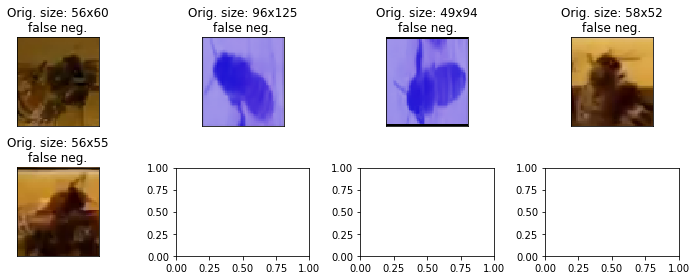

In [74]:
false_neg_mask = [i for i,result in enumerate(results) if result == 1]
false_negatives = img_store.images_for_display[false_neg_mask]
original_false_neg_shapes = [image.shape for image in raw_images[false_neg_mask]]
show_results(false_negatives, original_false_neg_shapes, "false neg.")

We can see these false negatives show some common issues as well:

1. __Shadows__ - like before, a number of these images display prominent shadows, which may have confused the network.
2. __Partials__ - many of these images show either more than 1 bee or only parts of bees. This could easily confuse the network, as these kinds of images are essentially incomplete.

## Rotated + Mirrored Transformations

In [144]:
grid_params = {
    "conv__filters_1" : [32],
    "conv__filters_2" : [48],
    "conv__filters_3" : [64],
    "density_units_1" : [256],
    "density_units_2" : [64],
    "batch_size" : [64],
    "epochs" : [50]
}

datagen_params = {
    "horizontal_flip" : True,    
    "vertical_flip" : True,
    "rotation_range" : True
}

best_rotated_model = _gridSearchCNN(
    data, grid_params, 
    datagen_params = datagen_params, 
    random_state=random_state,
    optimizer = RMSprop(lr=0.0001, decay=1e-5),
    get_best = True
)

Found 3326 validated image filenames belonging to 2 classes.
Found 1109 validated image filenames belonging to 2 classes.
Epoch 1/50
51/51 [==============================] - 48s 938ms/step - loss: 0.5462 - binary_accuracy: 0.7586 - val_loss: 0.5050 - val_binary_accuracy: 0.7628
Epoch 2/50
51/51 [==============================] - 48s 935ms/step - loss: 0.4814 - binary_accuracy: 0.7633 - val_loss: 0.3886 - val_binary_accuracy: 0.7628
Epoch 3/50
51/51 [==============================] - 32s 636ms/step - loss: 0.3560 - binary_accuracy: 0.8129 - val_loss: 0.3154 - val_binary_accuracy: 0.8386
Epoch 4/50
51/51 [==============================] - 30s 593ms/step - loss: 0.2969 - binary_accuracy: 0.8857 - val_loss: 0.3055 - val_binary_accuracy: 0.8702
Epoch 5/50
51/51 [==============================] - 31s 616ms/step - loss: 0.2695 - binary_accuracy: 0.8945 - val_loss: 0.1853 - val_binary_accuracy: 0.9243
Epoch 6/50
51/51 [==============================] - 30s 587ms/step - loss: 0.2286 - binary_ac

In [145]:
best_rotated_model

{'best_model': <keras.engine.sequential.Sequential at 0x1906e3fd240>,
 'best_score': 0.9909828674481514,
 'best_params': {'conv__filters_1': 32,
  'conv__filters_2': 48,
  'conv__filters_3': 64,
  'density_units_1': 256,
  'density_units_2': 64,
  'batch_size': 64,
  'epochs': 50},
 'generators': [<keras_preprocessing.image.dataframe_iterator.DataFrameIterator at 0x1906e3624e0>,
 'best_history': <keras.callbacks.History at 0x1906e560860>,
 'incorrect_indeces': Int64Index([1911, 2367, 4980, 1361, 1673, 2335, 3478, 1302, 4978, 4994], dtype='int64')}

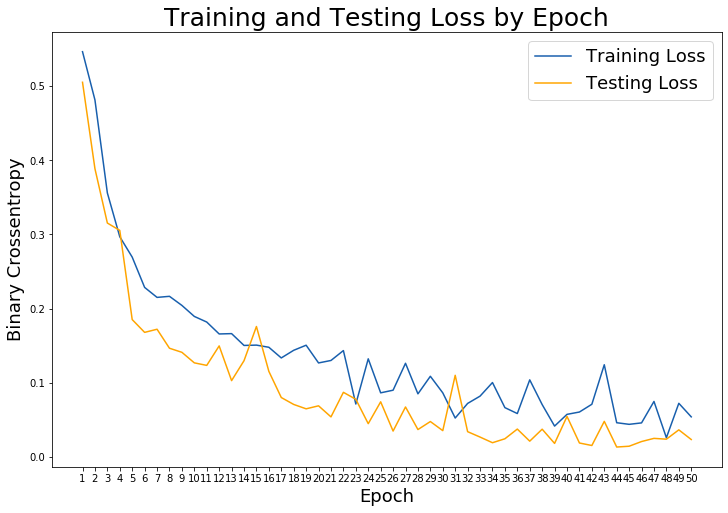

In [146]:
graph_loss(best_rotated_model["best_history"])

In [178]:
datagen_iter_test = best_rotated_model["generators"][1]
datagen_iter_test.reset()
STEP_SIZE_TEST= np.ceil(datagen_iter_test.n//datagen_iter_test.batch_size)

In [179]:
_preds = model.predict_generator(datagen_iter_test, steps=STEP_SIZE_TEST)
preds = (_preds >= .5).astype(int).flatten()

In [180]:
rot_preds = pd.DataFrame({
    "file"       : datagen_iter_test.filenames,
    "has_varroa" : datagen_iter_test.classes,
    "pred"       : preds
})

In [185]:
(rot_preds["has_varroa"] == rot_preds["pred"]).value_counts(normalize=True)

True     0.995491
False    0.004509
dtype: float64

~99.55% Acc.

In [175]:
rot_missed = rot_preds[rot_preds["has_varroa"] != rot_preds["pred"]]

,file,has_varroa,pred
136,040_047.png,1,0
155,031_065.png,1,0
314,028_025.png,0,1
496,040_401.png,1,0
987,005_448.png,0,1


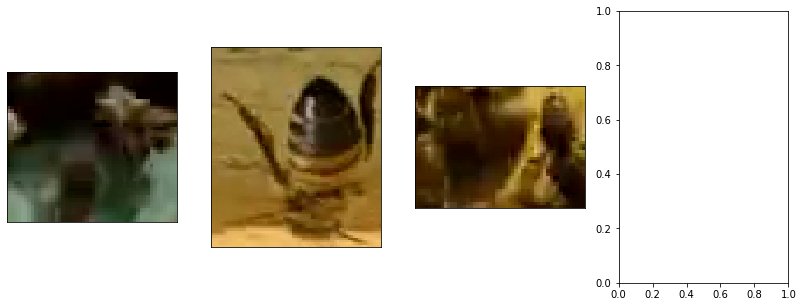

In [176]:
false_negatives_files = rot_missed[(rot_missed["has_varroa"] != rot_missed["pred"]) & (rot_missed["pred"] == 0)]["file"]
show_images(get_image_data(false_negatives_files))

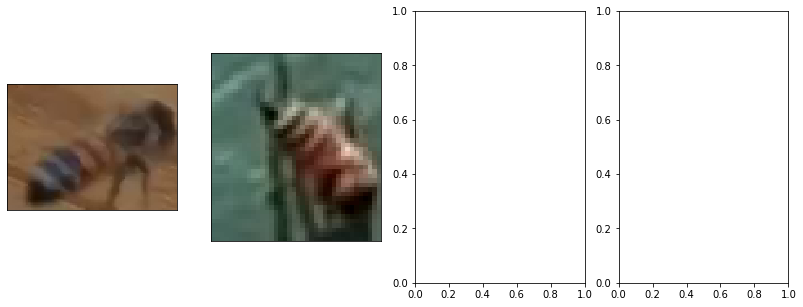

In [177]:
false_positives_files = rot_missed[(rot_missed["has_varroa"] != rot_missed["pred"]) & (rot_missed["pred"] == 1)]["file"]
show_images(get_image_data(false_positives_files))

#### Saving/Loading model weights

In [102]:
# best_rotated_model["best_model"].save("rotated_model.h5")

In [151]:
model = load_model('models/model.44-1.00.h5')

## Rotated + Mirrored + Brightness Transformations

In [ ]:
grid_params = {
    "conv__filters_1" : [32],
    "conv__filters_2" : [48],
    "conv__filters_3" : [64],
    "density_units_1" : [256],
    "density_units_2" : [64],
    "batch_size" : [64],
    "epochs" : [50]
}

datagen_params = {
    "horizontal_flip" : True,
    "vertical_flip" : True,
    "rotation_range" : True,
    "brightness_range" : [.2, 1.5]
}

best_bright_model = _gridSearchCNN(
    data, grid_params, 
    datagen_params = datagen_params, 
    random_state=random_state,
    optimizer = RMSprop(lr=0.0001, decay=1e-5),
    get_best = True
)

In [395]:
best_bright_model

{'best_model': <keras.engine.sequential.Sequential at 0x11c11fb5080>,
 'best_score': 0.9386834986474302,
 'best_params': {'conv__filters_1': 32,
  'conv__filters_2': 64,
  'density_units_1': 256,
  'density_units_2': 64,
  'batch_size': 32,
  'epochs': 50},
 'generators': [<keras_preprocessing.image.dataframe_iterator.DataFrameIterator at 0x11c118a2be0>,
 'best_history': <keras.callbacks.History at 0x11c16847d68>,
 'incorrect_indeces': Int64Index([1929, 5006, 1835, 4217, 4461, 3826,  532, 2367, 4246, 4980, 4428,
             4083,  526, 4021,  523, 4192, 4551,  271, 1486, 4567,  514, 4495,
             4975, 1830, 4194, 3992, 2358, 4091, 4175, 4433, 4475, 4044, 1778,
             1673, 2335, 3988, 3867,  538, 4998, 4978, 1582, 1500, 3985, 1854,
             4543,  525, 4257, 4468, 1543, 1618, 4994, 4608, 1639, 4615, 4990,
             4302, 1719, 4377, 4239, 1736, 2375, 3935, 4641,  527, 4317, 1898,
             1503, 1568],
            dtype='int64')}

In [100]:
graph_loss(best_bright_model["best_history"])

NameError: name 'best_bright_model' is not defined

In [385]:
bright_missed = data.loc[best_bright_model["incorrect_indeces"]]
bright_missed

,file,has_varroa
1911,040_047.png,1
4194,038_388.png,1
3101,018_045.png,0
3112,018_022.png,0
1673,040_401.png,1
2335,031_017.png,1
5120,012_011.png,0
1582,040_503.png,1
4543,038_356.png,1
1639,040_572.png,1


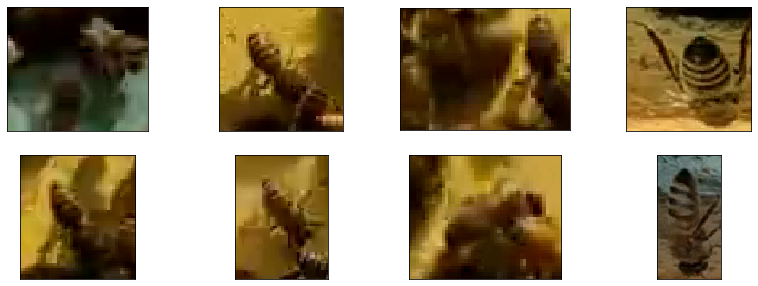

In [386]:
false_negatives_files = bright_missed[bright_missed["has_varroa"] == "1"]["file"]
show_images(get_image_data(false_negatives_files))

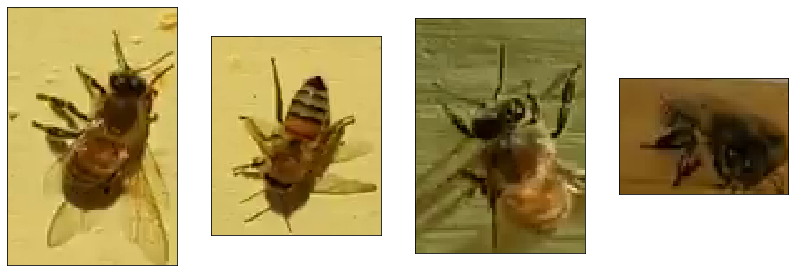

In [387]:
false_positives_files = bright_missed[bright_missed["has_varroa"] == "0"]["file"]
show_images(get_image_data(false_positives_files))

#### Saving/Loading weights

In [345]:
ih = ImageHandler(get_image_data(X["file"])).resize((54,50,3)).normalize()

In [346]:
results = model.predict_classes(ih.images).flatten()

In [358]:
mask= [pd.Series(results).values == X["has_varroa"].astype(int).values]

## Inverted transformation + original dataset

In [53]:
raw_images = get_image_data(data["file"].values)

inverted_img_store = ImageHandler(raw_images).resize(resizing).normalize().invert()

X = np.concatenate([inverted_img_store.images, ImageHandler(get_image_data(data["file"].values)).resize(resizing).normalize().images])

y = pd.concat([data["has_varroa"], data["has_varroa"]])

In [54]:
grid_params = {
    "conv__filters_1" : [16],
    "conv__filters_2" : [16],
    "density_units_1" : [124],
    "density_units_2" : [32]
}
best_inv_model = gridSearchCNN(X, y, grid_params, random_state=random_state)

***Good Accurary found: 96.21%***
***Good Accurary found: 96.89%***
***Good Accurary found: 97.70%***
***Good Accurary found: 97.75%***
***Good Accurary found: 98.06%***
***Good Accurary found: 98.60%***


In [357]:
type(results[0])

numpy.int32

In [56]:
best_inv_model["best_score"]

0.9860234445446348

In [57]:
best_rot_inv_model

{'best_model': <keras.engine.sequential.Sequential at 0x21910ebfcc0>,
 'best_score': 0.9860234445446348,
 'best_params': {'conv__filters_1': 16,
  'conv__filters_2': 16,
  'density_units_1': 124,
  'density_units_2': 32}}

## Grayscale transformation

In [355]:
X["has_varroa"].dtypes

dtype('O')

In [36]:
raw_images = get_image_data(data["file"].values)
grayscale_store = ImageHandler(raw_images).resize(resizing).normalize().grayscale()

X = grayscale_store.images

y = data["has_varroa"].iloc[grayscale_store.index]

In [37]:
grid_params = {
    "conv__filters_1" : [32],
    "conv__filters_2" : [16],
    "density_units_1" : [64],
    "density_units_2" : [32]
}
best_gray_model = gridSearchCNN(X, y, grid_params, random_state=random_state)

W0812 15:41:17.872095 10284 deprecation_wrapper.py:119] From C:\Users\rick_c137\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 15:41:17.890024 10284 deprecation_wrapper.py:119] From C:\Users\rick_c137\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 15:41:17.891993 10284 deprecation_wrapper.py:119] From C:\Users\rick_c137\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0812 15:41:17.902001 10284 deprecation_wrapper.py:119] From C:\Users\rick_c137\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0812 15:41:17.925936 10284 deprecation_wrapper.py:119] From C:

***Good Accurary found: 91.07%***
***Good Accurary found: 92.06%***
***Good Accurary found: 94.23%***
***Good Accurary found: 94.32%***


In [38]:
best_gray_model["best_score"]

0.9431920649233544

In [45]:
best_gray_model

{'best_model': <keras.engine.sequential.Sequential at 0x21893349208>,
 'best_score': 0.9431920649233544,
 'best_params': {'conv__filters_1': 32,
  'conv__filters_2': 16,
  'density_units_1': 64,
  'density_units_2': 32}}

convolutional part is more important
try 3 dense
data augmentation - common for image data
Randomly transform it, mirror at random (keras has data augmentation)

Try functional model instead of Sequential for visualization

## Visualizing the CNN
- https://www.analyticsvidhya.com/blog/2019/05/understanding-visualizing-neural-networks/
- https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/
- https://datascience.stackexchange.com/questions/14899/how-to-draw-deep-learning-network-architecture-diagrams
- https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/
- http://alexlenail.me/NN-SVG/LeNet.html
- https://www.kdnuggets.com/2016/11/intuitive-explanation-convolutional-neural-networks.html/3
- https://datascience.stackexchange.com/questions/14899/how-to-draw-deep-learning-network-architecture-diagrams

In [ ]:
false_negative_files = data.loc[results2[results2 == 1].index]["file"].unique()
show_bad_images(false_negative_files, ["false neg."] * len(false_negative_files), ncols = 6, height = 2)

In [ ]:
def get_image_data(files):
    IMAGE_FILE_ROOT = './data/bee_imgs/' 
    return [imageio.imread("{}{}".format(IMAGE_FILE_ROOT, file)) for file in files]

In [ ]:
raw_images = get_image_data(data["file"].values)

from image_handler import ImageHandler

img_store = ImageHandler(raw_images)

ImageHandler._images.shape

## Assumptions

- ignoring annotated factors
- varroa images only from 1 location - v. limiting
- single bee images
- 

## Conclustions and Recommendations

# TO DO 
- ~~Organize code w/OOP or functional design~~
- ~~try grayscale w/inverted colors (no good)~~
- ~~Reorg Problem Statement ( shorten, group, and spell check!) Avoid first person - scientific ("we")~~
- Reorg the flow of data
- Update table of contents
- Fill in documentation for functions
- Try AWS for all iterations

## Source Documentation
- [Honey Bee Annotated Image Dataset (Kaggle)](https://www.kaggle.com/jenny18/honey-bee-annotated-images)
- [Jeremy Jordan](https://www.jeremyjordan.me/batch-normalization/)